In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('..')

In [35]:
from medusapy import medusa
from medusapy import medusa_model

In [5]:
import json

In [36]:
import glob
path2train = '../resources/train_data/*'
train = []
for name in glob.glob(path2train):
    with open(name) as f:
        train = train + json.load(f)

In [37]:
inactive_color = "#EF476F"
active_color = "#23CE6B"

In [38]:
train[0].keys()

dict_keys(['is_inactive?', 'labeling_dt', 'sample'])

In [39]:
uno = train[-1]
uno["sample"]

{'t_n_villages_with_population_decrease': 0,
 'estimated_tribe': 3,
 't_5_time_difference_in_days': 0,
 't_1_new_village_conquered': 0,
 't_7_time_difference_in_days': 0,
 't_new_village_conquered': 0,
 't_7_total_villages': 0,
 't_6_has_data?': 0,
 't_7_population_decrease': 0,
 't_2_lost_village_destroyed': 0,
 't_5_population_decrease': 0,
 't_6_new_village_conquered': 0,
 't_new_village_founded': 0,
 't_4_lost_village_conquered': 0,
 't_2_new_village_conquered': 0,
 't_6_n_villages_with_population_stuck': 0,
 'server_days_from_start': 0,
 't_4_population_decrease': 0,
 't_3_has_increase?': 0,
 't_7_population_decrease_by_destroyed': 0,
 't_5_total_villages': 0,
 't_5_population_decrease_by_destroyed': 0,
 't_7_has_data?': 0,
 't_2_population_increase': 0,
 't_6_lost_village_destroyed': 0,
 't_2_population_decrease_by_conquered': 0,
 't_4_population_decrease_by_destroyed': 0,
 't_4_population_increase_by_conquered': 0,
 't_4_has_increase?': 0,
 't_3_population_decrease': 0,
 't_7_n_

# Prepare train data

### Get only fe_type -> ndays_1

In [8]:
train = [x for x in train if x["sample"]["fe_type"] == "ndays_1"]

In [9]:
train[0]

{'inactive_in_future': True,
 'sample': {'fe_struct': {'center_mass_x': -107.0,
   'center_mass_y': -9.0,
   'date': '2022-10-03',
   'distance_to_origin': 107.38,
   'inactive_in_current': 'undefined',
   'n_villages': 1,
   'player_id': 'https://ts100.x10.europe.travian.com--P--3708',
   'total_population': 65,
   'tribes_summary': {'teutons': 1}},
  'fe_type': 'ndays_1'}}

In [14]:
len(train)

688

### Eval distribution of target classes

In [11]:
future_inactive, future_active = [], []
none = [future_inactive.append(x) if x["inactive_in_future"] == True else future_active.append(x) for x in train]

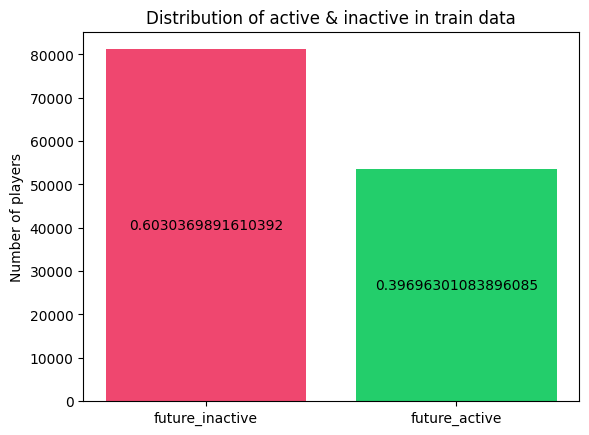

In [12]:
fig, ax = plt.subplots()

x = ["future_inactive", "future_active"]
y = [len(future_inactive), len(future_active)]
perct = [len(future_inactive)/len(train), len(future_active)/len(train)]
colors = [inactive_color, active_color]

p = ax.bar(x, y, color=colors)
ax.bar_label(p, labels=perct, label_type='center', fmt="%.2f%%")

ax.set_ylabel("Number of players")
ax.set_title("Distribution of active & inactive in train data")

plt.show()

### Player Id frequency 

In [13]:
from collections import Counter
ids = [x["sample"]["fe_struct"]["player_id"] for x in train]
p_id_freq = dict(Counter(ids))
appereance = dict(Counter(p_id_freq.values()))
items = list(appereance.items())
items.sort()
x, y = [], []
none = [(x.append(i[0]), y.append(i[1])) for i in items]

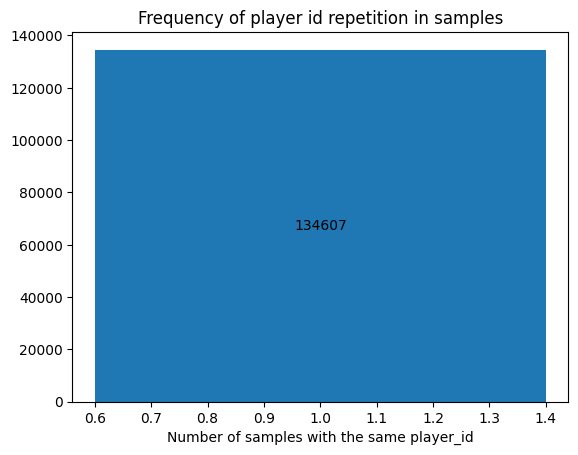

In [14]:
fig, ax = plt.subplots()


p = ax.bar(x, y)
ax.bar_label(p, label_type='center')

#ax.set_ylabel("Number of a player id appereance")
ax.set_xlabel("Number of samples with the same player_id")
ax.set_title("Frequency of player id repetition in samples")

plt.show()

### Prepare the data

In [40]:
def add_y(sample):
    #row = sample["sample"]
    x = medusa_model.prepare_row(sample["sample"])
    x["y"] = 1 if (sample["is_inactive?"] == True) else 0
    return x
    

In [17]:
train[0]

{'is_inactive?': False,
 'labeling_dt': '2023-05-01T00:00:00.000Z',
 'sample': {'t_n_villages_with_population_decrease': 0,
  'estimated_tribe': 5,
  't_5_time_difference_in_days': 0,
  't_1_new_village_conquered': 0,
  't_7_time_difference_in_days': 0,
  't_new_village_conquered': 0,
  't_7_total_villages': 0,
  't_6_has_data?': 0,
  't_7_population_decrease': 0,
  't_2_lost_village_destroyed': 0,
  't_5_population_decrease': 0,
  't_6_new_village_conquered': 0,
  't_new_village_founded': 0,
  't_4_lost_village_conquered': 0,
  't_2_new_village_conquered': 0,
  't_6_n_villages_with_population_stuck': 0,
  'server_days_from_start': 0,
  't_4_population_decrease': 0,
  't_3_has_increase?': 0,
  't_7_population_decrease_by_destroyed': 0,
  't_5_total_villages': 0,
  't_5_population_decrease_by_destroyed': 0,
  't_7_has_data?': 0,
  't_2_population_increase': 0,
  't_6_lost_village_destroyed': 0,
  't_2_population_decrease_by_conquered': 0,
  't_4_population_decrease_by_destroyed': 0,
  '

In [41]:
data = [add_y(x) for x in train]
data[0]

{'t_n_villages_with_population_decrease': 0,
 'estimated_tribe': 5,
 't_5_time_difference_in_days': 0,
 't_1_new_village_conquered': 0,
 't_7_time_difference_in_days': 0,
 't_new_village_conquered': 0,
 't_7_total_villages': 0,
 't_6_has_data?': 0,
 't_7_population_decrease': 0,
 't_2_lost_village_destroyed': 0,
 't_5_population_decrease': 0,
 't_6_new_village_conquered': 0,
 't_new_village_founded': 0,
 't_4_lost_village_conquered': 0,
 't_2_new_village_conquered': 0,
 't_6_n_villages_with_population_stuck': 0,
 'server_days_from_start': 0,
 't_4_population_decrease': 0,
 't_3_has_increase?': 0,
 't_7_population_decrease_by_destroyed': 0,
 't_5_total_villages': 0,
 't_5_population_decrease_by_destroyed': 0,
 't_7_has_data?': 0,
 't_2_population_increase': 0,
 't_6_lost_village_destroyed': 0,
 't_2_population_decrease_by_conquered': 0,
 't_4_population_decrease_by_destroyed': 0,
 't_4_population_increase_by_conquered': 0,
 't_4_has_increase?': 0,
 't_3_population_decrease': 0,
 't_7_n_

In [42]:
from utils import select_players

In [43]:
included = select_players(data, 0.33)

In [44]:
df = pd.DataFrame(data)
df.head(1)

,t_n_villages_with_population_decrease,estimated_tribe,t_5_time_difference_in_days,t_1_new_village_conquered,t_7_time_difference_in_days,t_new_village_conquered,t_7_total_villages,t_6_has_data?,t_7_population_decrease,t_2_lost_village_destroyed,...,t_total_population,t_3_n_villages_with_population_increase,t_2_n_villages_with_population_stuck,t_1_total_villages,t_4_new_village_founded,t_2_n_villages_with_population_decrease,t_6_population_decrease,t_2_total_villages,t_6_n_villages_with_population_increase,y
0,0,5,0,0,0,0,0,0,0,0,...,63226,0,0,0,0,0,0,0,0,0


In [45]:
df.dtypes

t_n_villages_with_population_decrease      int64
estimated_tribe                            int64
t_5_time_difference_in_days                int64
t_1_new_village_conquered                  int64
t_7_time_difference_in_days                int64
                                           ...  
t_2_n_villages_with_population_decrease    int64
t_6_population_decrease                    int64
t_2_total_villages                         int64
t_6_n_villages_with_population_increase    int64
y                                          int64
Length: 150, dtype: object

In [46]:
mask = df["player_id"].isin(included)
df_test = df[mask]
df_train = df[~mask]

# Model fitting

### Split sample

In [47]:
from utils import split_x_y_pid

In [48]:
X_train, y_train, p_id_train = split_x_y_pid(df_train)
X_test, y_test, p_id_test = split_x_y_pid(df_test)

### Fit

In [49]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=2000, max_depth=3)

In [50]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1.73 s, sys: 455 µs, total: 1.73 s
Wall time: 1.79 s


RandomForestClassifier(max_depth=3, n_estimators=2000)

### Evaluation

In [51]:
clf.score(X_test, y_test)

0.9166666666666666

In [52]:
pd.DataFrame(clf.feature_importances_, index=df.columns.to_list()[:-2], columns=["feature importance"]).sort_values("feature importance", ascending=False)

,feature importance
t_1_population_increase_by_founded,0.393470
t_total_villages,0.308863
has_alliance?,0.289413
estimated_tribe,0.008255
t_4_new_village_conquered,0.000000
...,...
t_3_time_difference_in_days,0.000000
t_2_population_decrease,0.000000
t_6_total_villages,0.000000
t_2_has_data?,0.000000


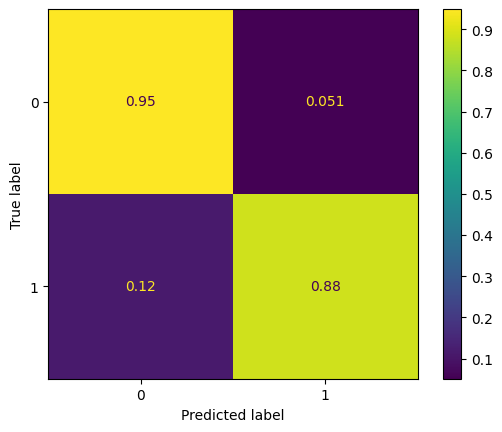

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
_ = disp.plot()

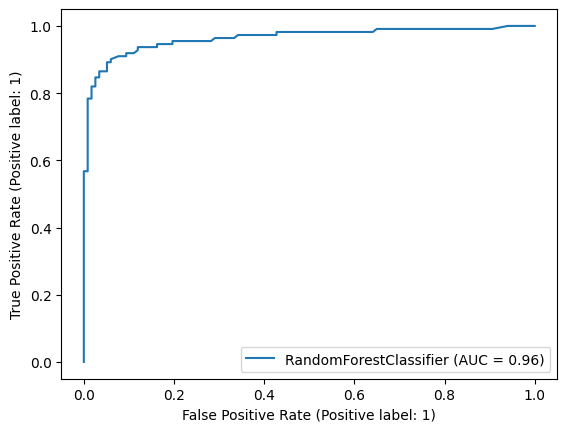

In [54]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [55]:
prediction = clf.predict(X_test)

### Comparation of Active & Inactive test vs prediction

In [56]:
tmp = pd.DataFrame(y_test).value_counts().to_dict()
test = [tmp[(True,)], tmp[(False,)]]

In [57]:
tmp = pd.DataFrame(prediction).value_counts().to_dict()
pred = [tmp[(True,)], tmp[(False,)]]

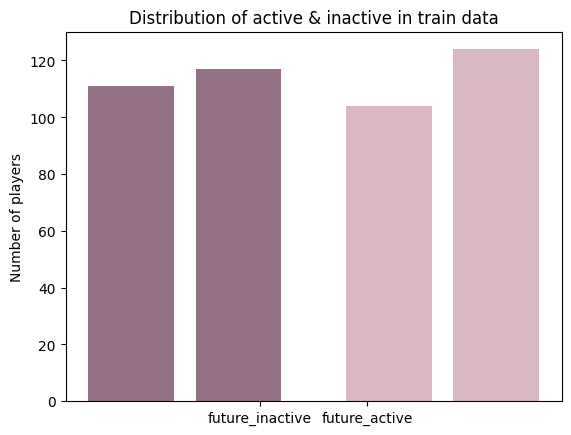

In [58]:
import numpy as np

pred_color = "#D9B8C4"
test_color = "#957186"

fig, ax = plt.subplots()

labels = ["future_inactive", "future_active"]
x = np.arange(len(labels))
width = 0.2

ax.bar(x - width-1, test, color=test_color)
ax.bar(x + width+1, pred, color=pred_color)
ax.set_xticks(x, labels)

ax.set_ylabel("Number of players")
ax.set_title("Distribution of active & inactive in train data")

plt.show()

# Store the model

In [61]:
import pickle
import datetime
now = datetime.datetime.now()
date_time_name = now.strftime("%m_%d_%Y_%H:%M:%S")
pickle.dump(clf, open(f"../trained_models/medusa_model__{date_time_name}.pkl", 'wb'))